<a href="https://colab.research.google.com/github/kellyose/nigeria-houses-price-prediction/blob/main/house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

## Load the Dataset
Here, we load the Nigeria houses dataset from a CSV file and display the first 5 rows to understand its structure.

In [180]:
df = pd.read_csv('/content/drive/MyDrive/nigeria_houses_data.csv')
df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price
0,6.0,5.0,5.0,4.0,Detached Duplex,Mabushi,Abuja,450000000.0
1,4.0,5.0,5.0,4.0,Terraced Duplexes,Katampe,Abuja,800000000.0
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0


## Inspect Data Structure
We use `df.info()` to check data types and ensure there are no missing values.

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  float64
 1   bathrooms      24326 non-null  float64
 2   toilets        24326 non-null  float64
 3   parking_space  24326 non-null  float64
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(5), object(3)
memory usage: 1.5+ MB


## Data Preprocessing: Convert Float to Integer
Convert numerical columns from float to integer for consistency, as they represent counts (e.g., bedrooms).

In [182]:
df[['bathrooms','bedrooms','toilets','parking_space']] = df[['bathrooms','bedrooms','toilets','parking_space']].astype(int)

## Verify Preprocessing
Check the updated data types after conversion.

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24326 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24326 non-null  int64  
 1   bathrooms      24326 non-null  int64  
 2   toilets        24326 non-null  int64  
 3   parking_space  24326 non-null  int64  
 4   title          24326 non-null  object 
 5   town           24326 non-null  object 
 6   state          24326 non-null  object 
 7   price          24326 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 1.5+ MB


In [184]:
df.describe()

,bedrooms,bathrooms,toilets,parking_space,price
count,24326.000000,24326.000000,24326.000000,24326.000000,2.432600e+04
mean,4.338814,4.600798,5.176355,4.041725,3.013802e+08
std,1.138497,1.163161,1.226253,1.399936,1.220403e+10
min,1.000000,1.000000,1.000000,1.000000,9.000000e+04
25%,4.000000,4.000000,5.000000,4.000000,5.200000e+07
50%,4.000000,5.000000,5.000000,4.000000,8.500000e+07
75%,5.000000,5.000000,6.000000,4.000000,1.600000e+08
max,9.000000,9.000000,9.000000,9.000000,1.800000e+12


In [185]:
print(df['title'].unique())
print(df['town'].unique()[:10])  # Just the first few
print(df['state'].unique())

['Detached Duplex' 'Terraced Duplexes' 'Semi Detached Duplex'
 'Detached Bungalow' 'Block of Flats' 'Semi Detached Bungalow'
 'Terraced Bungalow']
['Mabushi' 'Katampe' 'Lekki' 'Ajah' 'Epe' 'Lokogoma District' 'Oredo'
 'Victoria Island (VI)' 'Mowe Ofada' 'Ikeja']
['Abuja' 'Lagos' 'Edo' 'Ogun' 'Oyo' 'Imo' 'Anambara' 'Rivers' 'Enugu'
 'Kaduna' 'Kwara' 'Nasarawa' 'Abia' 'Delta' 'Akwa Ibom' 'Osun' 'Ekiti'
 'Cross River' 'Kogi' 'Plateau' 'Kano' 'Katsina' 'Bayelsa' 'Borno' 'Niger']


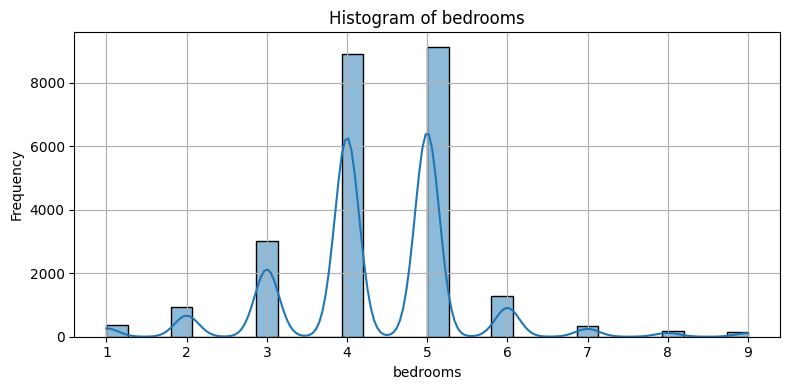

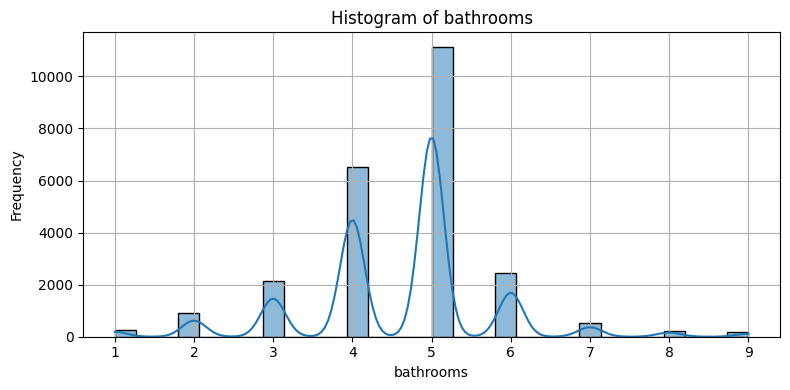

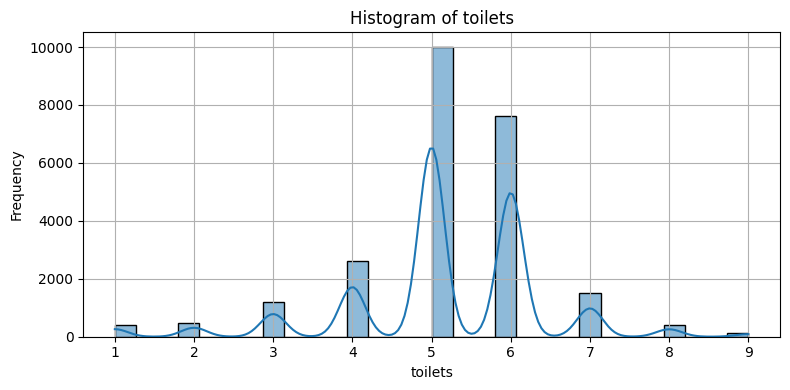

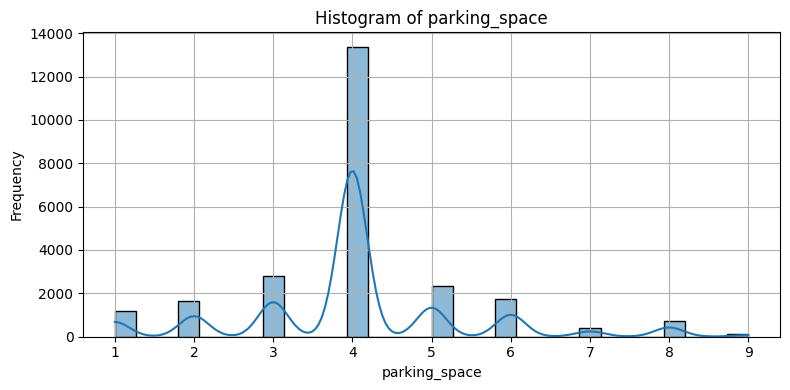

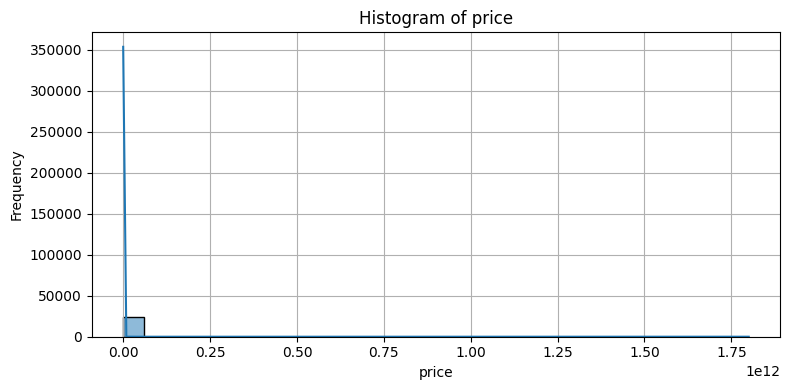

In [186]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns

# Plot histograms
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


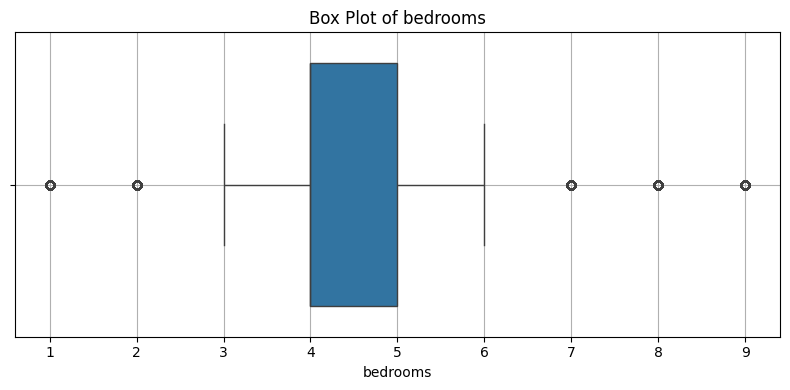

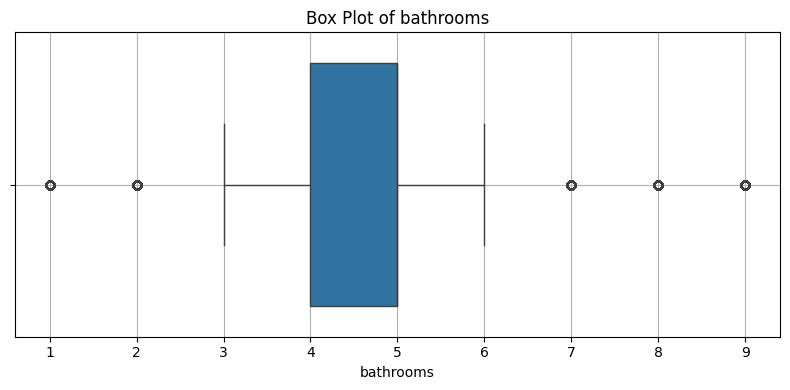

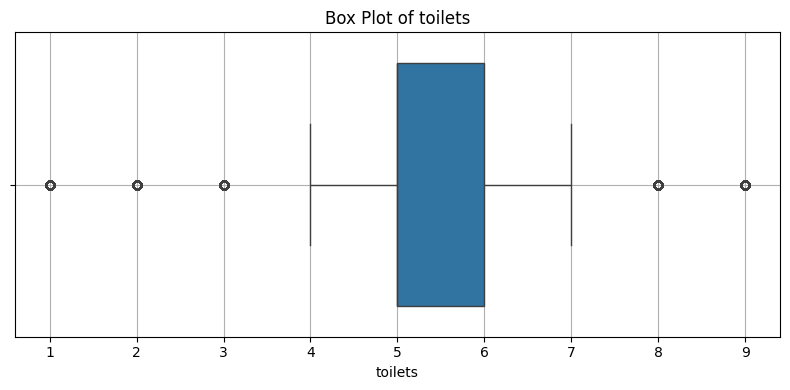

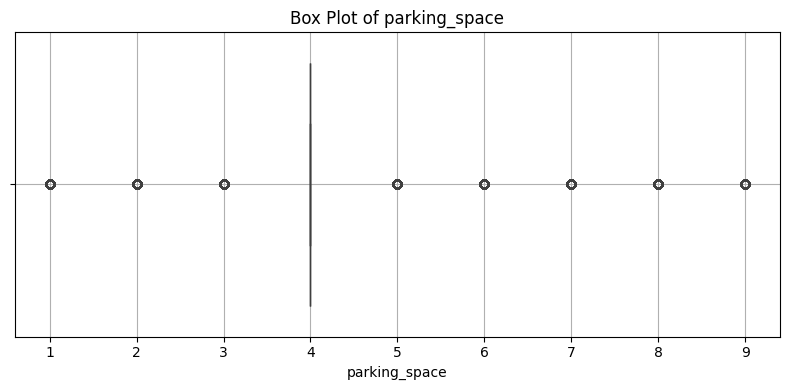

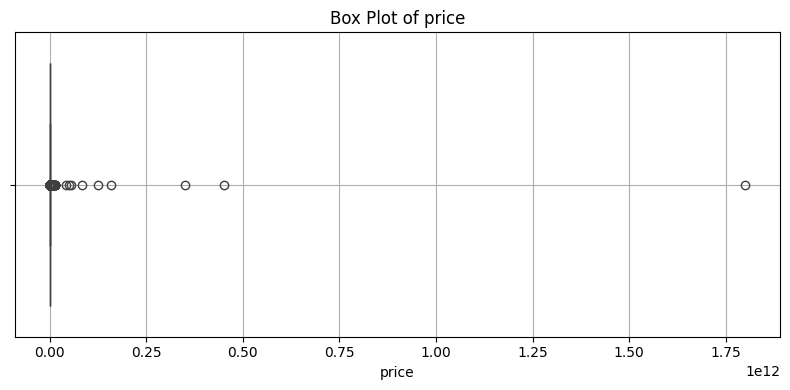

In [187]:
# Plot box plots
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Box Plot of {col}")
    plt.xlabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [188]:
# Check top 1% of prices
price_threshold = df['price'].quantile(0.99)
outliers = df[df['price'] > price_threshold]
print(outliers)

       bedrooms  bathrooms  toilets  parking_space            title  \
244           5          5        6              4  Detached Duplex   
342           6          5        7              8  Detached Duplex   
502           1          1        2              4  Detached Duplex   
504           4          5        5              4   Block of Flats   
588           5          5        6              1  Detached Duplex   
...         ...        ...      ...            ...              ...   
23948         4          4        5              4  Detached Duplex   
24000         9          5        5              4  Detached Duplex   
24023         9          5        5              4  Detached Duplex   
24127         5          5        6              4  Detached Duplex   
24269         5          5        6              8  Detached Duplex   

                   town  state         price  
244               Ikoyi  Lagos  1.500000e+09  
342               Ikoyi  Lagos  1.600000e+09  
502   

## Remove Outliers
House prices are highly skewed (some reach 1.8 trillion NGN). We remove the top 1% to improve model performance.

In [189]:
# Log-transform price
df['price'] = np.log1p(df['price'])

# Cap extreme outliers
price_99th = df['price'].quantile(0.99)
df = df[df['price'] <= price_99th]

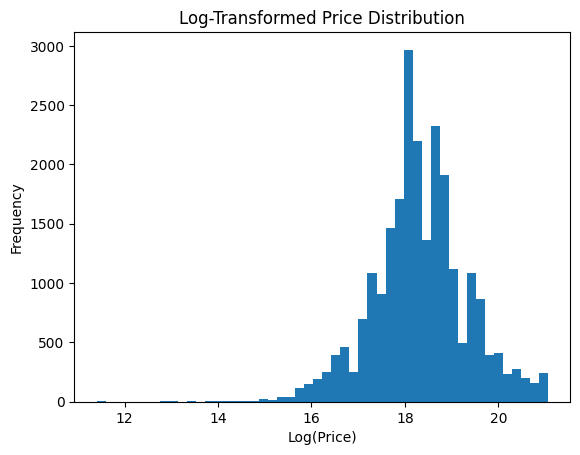

Skewness: -0.11


In [190]:
# Check distribution
plt.hist(df['price'], bins=50)
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()
print(f"Skewness: {df['price'].skew():.2f}")

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24083 entries, 0 to 24325
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24083 non-null  int64  
 1   bathrooms      24083 non-null  int64  
 2   toilets        24083 non-null  int64  
 3   parking_space  24083 non-null  int64  
 4   title          24083 non-null  object 
 5   town           24083 non-null  object 
 6   state          24083 non-null  object 
 7   price          24083 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 1.7+ MB


## Explore Categorical Features
Count unique values in 'town' to understand its cardinality (useful for encoding later).

In [192]:
df['town'].nunique()

189

In [ ]:
!pip install category_encoders

## Feature Engineering
Create new features to capture relationships in the data, enhancing model performance.

In [194]:
# Feature engineering
df['total_rooms'] = df['bedrooms'] + df['bathrooms'] + df['toilets']
df['bathrooms_per_bedroom'] = df['bathrooms'] / df['bedrooms'].replace(0, 1)
df['bedrooms_per_total_rooms'] = df['bedrooms'] / df['total_rooms']

## Linear Regression Model
Implement a Linear Regression model with preprocessing and log transformation for skewed prices.

In [195]:
# Stratified split
df['price_bin'] = pd.qcut(df['price'], q=5, labels=False)
X = df.drop(['price', 'price_bin'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=df['price_bin'], random_state=42)

# Log-transform the target variable
y_train_log = np.log1p(y_train)  # log1p = log(1 + x) to handle zero values
y_test_log = np.log1p(y_test)

# Define preprocessing steps
numeric_features = ['bedrooms', 'bathrooms', 'toilets', 'parking_space', 'total_rooms',
                    'bathrooms_per_bedroom', 'bedrooms_per_total_rooms']
categorical_onehot = ['title', 'state']
categorical_target = ['town']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_onehot),
        ('cat_target', TargetEncoder(), categorical_target)
    ])

# Create pipeline with Linear Regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model on log-transformed target
model.fit(X_train, y_train_log)

# Predict and convert back to original scale
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Convert predictions back from log scale
y_test_orig = np.expm1(y_test_log)  # Convert test values back to original scale

# Evaluate
mae = mean_absolute_error(y_test_orig, y_pred)  # MAE in NGN
r2_log = r2_score(y_test_log, y_pred_log)  # R² on log scale
r2_orig = r2_score(y_test_orig, y_pred)  # R² on original scale

print(f"\nLinear Regression MAE (NGN): {mae:,.2f}")
print(f"Linear Regression R² (log scale): {r2_log:.4f}")
print(f"Linear Regression R² (original scale): {r2_orig:.4f}")

# Feature importance via coefficients
feature_names = (numeric_features +
                 model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist() +
                 categorical_target)
coefficients = model.named_steps['regressor'].coef_

print("\nTop 5 Features by Absolute Coefficient Value:")
for name, coef in sorted(zip(feature_names, np.abs(coefficients)), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{name}: {coef:.4f}")


Linear Regression MAE (NGN): 0.43
Linear Regression R² (log scale): 0.6500
Linear Regression R² (original scale): 0.6586

Top 5 Features by Absolute Coefficient Value:
town: 0.7781
state_Plateau: 0.1614
state_Katsina: 0.0792
state_Borno: 0.0513
state_Cross River: 0.0407


## XGBoost Model
Implement an XGBoost model for comparison, using the same preprocessing

In [196]:
# Stratified split
df['price_bin'] = pd.qcut(df['price'], q=5, labels=False)
X = df.drop(['price', 'price_bin'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=df['price_bin'], random_state=42)

# Preprocessing pipeline
numeric_features = ['bedrooms', 'bathrooms', 'toilets', 'parking_space', 'total_rooms',
                    'bathrooms_per_bedroom', 'bedrooms_per_total_rooms']
categorical_onehot = ['title', 'state']
categorical_target = ['town']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), categorical_onehot),
        ('cat_target', TargetEncoder(), categorical_target)
    ])

# Model pipeline with XGBoost
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=200, max_depth=5, random_state=42,
                               objective='reg:squarederror'))
])

# Train and evaluate
model.fit(X_train, y_train)
y_pred_log = model.predict(X_test)
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2_log = r2_score(y_test, y_pred_log)
r2_orig = r2_score(y_test_orig, y_pred_orig)
print(f"\nXGBoost MAE (NGN): {mae:,.2f}")
print(f"XGBoost R² (log scale): {r2_log:.4f}")
print(f"XGBoost R² (original scale): {r2_orig:.4f}")



XGBoost MAE (NGN): 53,851,020.25
XGBoost R² (log scale): 0.7136
XGBoost R² (original scale): 0.7138


## XGBoost Feature Importance
Extract and display the top 5 most important features from the XGBoost model.

In [197]:
# Feature importance
feature_names = (numeric_features +
                 model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist() +
                 categorical_target)
importances = model.named_steps['regressor'].feature_importances_
print("\nTop 5 Feature Importance:")
for name, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{name}: {imp:.4f}")


Top 5 Feature Importance:
title_Detached Duplex: 0.2545
town: 0.2032
bedrooms: 0.1093
title_Detached Bungalow: 0.0512
state_Ogun: 0.0402
